In [1]:
import os
from control.matlab import ss, lsim, linspace, c2d
from PID import PID
from sim3 import vt,dc,ap,qd
import matplotlib.pyplot as plt
import numpy as np
import time
import statistics

In [2]:
# you can use vt, dc and ap
a = vt()
print(a.sysd)
# a.ref = [0] * 251 + [2] * 250
# a.thres=6

A = [[0.84648172]]

B = [[0.09211097]]

C = [[1.]]

D = [[0.]]

dt = 0.02



In [3]:
#only for vt
control_inputs = []
measures=[]
x_just_before = 0
xout=1
pid = PID(P=a.p, I=a.i, D=a.d, current_time=0)
pid.setWindup(100)
pid.setSampleTime(a.Ts)
for i in range(0, a.slot+1):
    a.y_real_arr.append(a.yreal)
    # sensor attack here
    a.score.append(a.s)
    pid.SetPoint = a.ref[i]
    pid.update(feedback_value=a.ymeasure, current_time=i * a.Ts)
    a.cin = pid.output
#     print(a.ymeasure,i,a.cin,xout)
    if a.cin>5:
        a.cin=5
    elif a.cin<-5:
        a.cin = -5
    else:
        a.cin=a.cin
    control_inputs.append(a.cin)
    if i>a.place:
        if (a.score[-1]==a.thres):
            a.att=a.drift
        else:
            a.att = a.thres+a.drift-a.score[-1]
    
    yout, T, xout = lsim(a.sysc, a.cin, [0, a.Ts], a.ymeasure)
    ymax, T, xout1 = lsim(a.sysc, a.maxc, [0, a.Ts], a.ymeasure)
    yout2, T, xout2 = lsim(a.sysc, a.cin, [0, a.Ts], a.yreal)
    a.yreal=yout2[-1]
    ypred = yout[-1]
    a.ymeasure = yout[-1]-a.att
#     if i>a.place-1:
#         a.ymeasure = min(ymax[-1],yout[-1]-a.att)
#         print(a.ymeasure,a.cin)
    a.s = a.score[-1]+abs(ypred-a.ymeasure)-a.drift
    if(a.s<0):
        a.s=0
    if(i==a.place+1):
        x_just_before = xout
    measures.append(a.ymeasure)

# print(control_inputs[a.place+2:])
# print(a.score[a.place+2:])
# print(x_just_before)


In [4]:
# ---------------------------------------
max_k = 450
attack_inputs = control_inputs[a.place+2:]
print('attack_inputs=', attack_inputs)
for j in range(0, len(attack_inputs)-10):
    temp = attack_inputs[j:j+10]
    if 5 in temp or 5 in temp:
        continue
    vari = statistics.variance(temp)
    print(vari, end= ' ')
    if(vari < 1e-6):
        max_k = j
        break
print('max_k', max_k)

attack_inputs = np.array([control_inputs[a.place+2:]])
x_just_before = x_just_before[-1]
print(x_just_before, len(x_just_before.shape))
if len(x_just_before.shape) == 0:
    x_a = np.array([[x_just_before]])
else:
    x_a = np.array([[item] for item in x_just_before])
# def get_safetime(self, x_a, safe_set_lo, safe_set_up, control_list: np.array, max_k)
safe_set_lo = a.safeset['lo']
safe_set_up = a.safeset['up']
k = a.est.get_safetime(x_a, safe_set_lo, safe_set_up, attack_inputs, max_k)
print(k)

# ---------------------------------------
        


attack_inputs= [1.6666725064903742, 5, 5, 5, 5, 5, 5, 4.862332517356338, 4.786998639049702, 4.786998639049702, 4.578899029148652, 4.578899029148652, 4.370839361894953, 4.370839361894953, 4.172713289453148, 4.172713289453148, 3.990295496189999, 3.990295496189999, 3.8264845703077857, 3.8264845703077857, 3.6822248333060177, 3.6822248333060177, 3.557181534251689, 3.557181534251689, 3.4502281416178286, 3.4502281416178286, 3.35979177031078, 3.35979177031078, 3.284092572206534, 3.284092572206534, 3.221304765195524, 3.221304765195524, 3.169660509029703, 3.1468089074409002, 3.1468089074409002, 3.1089993436336165, 3.1089993436336165, 3.0784769077186747, 3.0784769077186747, 3.0540097873491137, 3.0540097873491137, 3.034531733762302, 3.034531733762302, 3.0191318277473984, 3.0191318277473984, 3.007040619730115, 3.007040619730115, 2.997614640193391, 2.997614640193391, 2.990320618636561, 2.9870832994790253, 2.9870832994790253, 2.9822337282919618, 2.9822337282919618, 2.978562147230217, 2.97856214723021

C:\Users\Mengyu\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


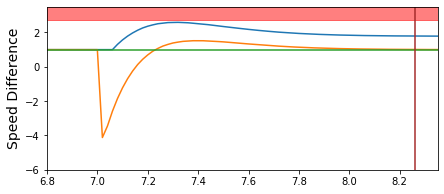

In [5]:
fig, ax = plt.subplots(figsize=(7, 3))
ax.set_ylim(-6,3.5)
ax.set_xlim(6.8,8.35)
ax.plot(a.t_arr, a.y_real_arr,label='real')
ax.plot(a.t_arr, measures,label='measure')
ax.plot(a.t_arr, a.ref,label='ref')
ax.axhspan(2.7, 3.5, color='r', alpha=0.5)
ax.axvline((a.place+2+k)*a.Ts, color='brown',label='stable')
ax.set_ylabel('Speed Difference', fontsize=14)
# ax.legend()
fig.show()
# fig.savefig('vt_unsafe_ref.pdf',bbox_inches='tight')
fig.savefig('vt_safe.pdf',bbox_inches='tight')
# fig.savefig('vt_unsafe_thres.pdf',bbox_inches='tight')

In [6]:
# you can use vt, dc and ap\
import math
a = dc()
print(a.sysd)
# a.ref = [math.pi / 2+1] * 71 + [-math.pi / 2] * 50
# a.thres =0.5

A = [[ 1.          0.08645683  0.00979615]
 [ 0.          0.13523578  0.06686454]
 [ 0.         -0.00133729  0.67015208]]

B = [[0.00155661]
 [0.01959229]
 [0.329652  ]]

C = [[1. 0. 0.]]

D = [[0.]]

dt = 0.2



In [7]:
#for ap and dc
control_inputs = []
measures = []
x_just_before = 0
pid = PID(P=a.p, I=a.i, D=a.d, current_time=0)
pid.setWindup(100)
pid.setSampleTime(a.Ts)
for i in range(0, a.slot+1):
    a.y_real_arr.append(a.yreal)
    # sensor attack here
    a.score.append(a.s)
    pid.SetPoint = a.ref[i]
#     print(a.ymeasure,i * a.Ts)
    pid.update(feedback_value=a.ymeasure, current_time=i * a.Ts)
    a.cin = pid.output

    if a.cin>20:
        a.cin=20
    elif a.cin<-20:
        a.cin = -20
    else:
        a.cin=a.cin
    control_inputs.append(a.cin)
    if i>a.place:
        if (a.score[-1]>a.thres):
            a.att=a.drift
        else:
            a.att = a.thres+a.drift-a.score[-1]
            x_just_before = xout 
    yout, T, xout = lsim(a.sysc, a.cin, [0, a.Ts], a.xmeasure)
    ymax,T,xout1 = lsim(a.sysc, a.maxc, [0, a.Ts], a.xmeasure)
    yout2, T, xout2 = lsim(a.sysc, a.cin, [0, a.Ts], a.xreal)
    a.yreal=yout2[-1]
    ypred = yout[-1]
    a.xmeasure = xout[-1, :].T
    a.xreal = xout2[-1, :].T
    a.ymeasure = yout[-1]-a.att
    if i>a.place and a.score[-1]<a.thres :
        print(i,a.s)
        
        if(ymax[-1]>a.ymeasure-a.att):
            a.ymeasure = max(ymax[-1],yout[-1]-a.att)
            a.xreal = xout1[-1, :].T
            a.xmeasure = xout1[-1, :].T
#             print(a.ymeasure, ypred)
    a.s = a.score[-1]+abs(ypred-a.ymeasure)-a.drift
#     print(a.s)
    if(a.s<0):
        a.s=0
    measures.append(a.ymeasure)
#waht you need
# print(control_inputs)
# print(x_just_before)

21 0
22 0.02106211332546338
23 0.043866816075044626
24 0.07272351961080806
25 0.10861468701941028
26 0.1445058544280125
27 0.19368622818864828


In [8]:
a.score

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.02106211332546338,
 0.043866816075044626,
 0.07272351961080806,
 0.10861468701941028,
 0.1445058544280125,
 0.19368622818864828,
 0.24595079773163248,
 0.24595079773163225,
 0.24595079773163203,
 0.2459507977316318,
 0.2459507977316316,
 0.24595079773163137,
 0.24595079773163114,
 0.24595079773163092,
 0.2459507977316307,
 0.24595079773163048,
 0.24595079773163026,
 0.24595079773163026,
 0.24595079773163026,
 0.24595079773163026,
 0.24595079773163026,
 0.24595079773163026,
 0.24595079773163026,
 0.24595079773163026,
 0.24595079773163026,
 0.24595079773163026,
 0.24595079773163026,
 0.24595079773163026,
 0.24595079773163026,
 0.24595079773163026,
 0.24595079773163026,
 0.24595079773163026,
 0.24595079773163026,
 0.24595079773163026,
 0.24595079773163026,
 0.24595079773163026,
 0.24595079773163026,
 0.24595079773163026,
 0.24595079773163026,
 0.24595079773163026,
 0.24595079773163026,
 0.2459507977

In [9]:
control_inputs[a.place+2:]

[-1.0743946294752873,
 -4.962320511307183,
 -9.481400254069987,
 -9.481400254069987,
 -18.01865118157179,
 -20,
 -20,
 -20,
 -20,
 -20,
 -16.845287373890557,
 -12.419269061869324,
 -8.743703281661936,
 -8.743703281661936,
 -3.7196483558625992,
 -2.394097896323676,
 -1.5567008222957934,
 -1.0994734815827916,
 -1.0994734815827916,
 -0.3197788609082366,
 -0.3197788609082366,
 -0.21651312544872714,
 -0.36743379797861275,
 -0.36743379797861275,
 -0.20618720141500435,
 -0.20618720141500435,
 -0.12323594403147403,
 -0.12323594403147403,
 -0.07417671037495321,
 -0.07526339424591222,
 -0.07526339424591222,
 -0.035363785048898116,
 -0.035363785048898116,
 -0.017583922604765066,
 -0.018665904859042716,
 -0.018665904859042716,
 -0.008290432669132007,
 -0.008290432669132007,
 -0.004606165804490969,
 -0.005383984916297602,
 -0.005383984916297602,
 -0.0026027786200939554,
 -0.0026027786200939554,
 -0.0014431390385360853,
 -0.0015626455968642695,
 -0.0015626455968642695,
 -0.0007316730792722454,
 -0.0

In [10]:
# ---------------------------------------
max_k = 450
attack_inputs = control_inputs[a.place+2:]
print('attack_inputs=', attack_inputs)
for j in range(0, len(attack_inputs)-10):
    temp = attack_inputs[j:j+10]
    if 20 in temp:
        continue
    vari = statistics.variance(temp)
    print(vari, end= ' ')
    if(vari < 1e-6):
        max_k = j
        print('this is temp')
        print(temp)
        break
print('max_k', max_k)

attack_inputs = np.array([control_inputs[a.place+2:]])
x_just_before = x_just_before[-1]
print(x_just_before, len(x_just_before.shape))
if len(x_just_before.shape) == 0:
    x_a = np.array([[x_just_before]])
else:
    x_a = np.array([[item] for item in x_just_before])
# def get_safetime(self, x_a, safe_set_lo, safe_set_up, control_list: np.array, max_k)
safe_set_lo = a.safeset['lo']
safe_set_up = a.safeset['up']
k = a.est.get_safetime(x_a, safe_set_lo, safe_set_up, attack_inputs, max_k)
print(k)

# ---------------------------------------
        


attack_inputs= [-1.0743946294752873, -4.962320511307183, -9.481400254069987, -9.481400254069987, -18.01865118157179, -20, -20, -20, -20, -20, -16.845287373890557, -12.419269061869324, -8.743703281661936, -8.743703281661936, -3.7196483558625992, -2.394097896323676, -1.5567008222957934, -1.0994734815827916, -1.0994734815827916, -0.3197788609082366, -0.3197788609082366, -0.21651312544872714, -0.36743379797861275, -0.36743379797861275, -0.20618720141500435, -0.20618720141500435, -0.12323594403147403, -0.12323594403147403, -0.07417671037495321, -0.07526339424591222, -0.07526339424591222, -0.035363785048898116, -0.035363785048898116, -0.017583922604765066, -0.018665904859042716, -0.018665904859042716, -0.008290432669132007, -0.008290432669132007, -0.004606165804490969, -0.005383984916297602, -0.005383984916297602, -0.0026027786200939554, -0.0026027786200939554, -0.0014431390385360853, -0.0015626455968642695, -0.0015626455968642695, -0.0007316730792722454, -0.0007316730792722454, -0.000391647

C:\Users\Mengyu\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


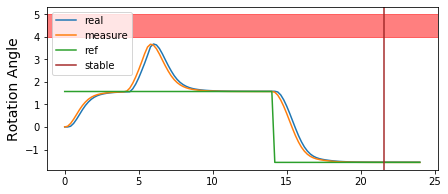

In [11]:
fig, ax = plt.subplots(figsize=(7, 3))
# ax.set_ylim(-5,5)
# ax.set_xlim(3,12)
ax.plot(a.t_arr, a.y_real_arr,label='real')
ax.plot(a.t_arr, measures,label='measure')
ax.plot(a.t_arr, a.ref,label='ref')
ax.axhspan(4, 5, color='r', alpha=0.5)
ax.axvline((a.place+2+k)*a.Ts, color='brown',label='stable')
ax.set_ylabel('Rotation Angle', fontsize=14)
ax.legend()
fig.show()
# fig.savefig('dc_unsafe_ref.pdf',bbox_inches='tight')
# fig.savefig('dc_safe.pdf',bbox_inches='tight')
# fig.savefig('vt_unsafe_thres.pdf',bbox_inches='tight')

In [12]:
len(a.ref)

121

In [13]:
a = qd()
print(a.sysc)
a.ref = [2] * 601 + [7.5] * 600 + [2] * 300


A = [[ 0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.   -9.81  0.    0.    0.    0.    0.    0.    0.  ]
 [ 9.81  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    1.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    1.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    1.    0.    0.    0.  ]]

B = [[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [2.13675214]
 [0.        ]
 [0.        ]
 [0.        ]]

C = [[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]

D = [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]



In [14]:
#for ap and dc
control_inputs = []
measures = []
x_just_before = 0
pid = PID(P=a.p, I=a.i, D=a.d, current_time=0)
pid.setWindup(100)
pid.setSampleTime(a.Ts)
for i in range(0, a.slot+1):
    a.y_real_arr.append(a.yreal)
    # sensor attack here
    a.score.append(a.s)
    pid.SetPoint = a.ref[i]
#     print(a.ymeasure,i * a.Ts)
    pid.update(feedback_value=a.ymeasure, current_time=i * a.Ts)
    a.cin = pid.output

    if a.cin>50:
        a.cin=50
    elif a.cin<-50:
        a.cin = -50
    else:
        a.cin=a.cin
    control_inputs.append(a.cin)
    if i>a.place:
        if (a.score[-1]==a.thres):
            a.att=a.drift
        else:
            a.att = a.thres+a.drift-a.score[-1]
            x_just_before = xout 
    yout, T, xout = lsim(a.sysc, a.cin, [0, a.Ts], a.xmeasure)
    yout2, T, xout2 = lsim(a.sysc, a.cin, [0, a.Ts], a.xreal)
    a.yreal=yout2[-1][-1]
    ypred = yout[-1][-1]
    a.xmeasure = xout[-1, :].T
    a.xreal = xout2[-1, :].T
    a.ymeasure = yout[-1][-1]-a.att
#     if i>a.place:
#         a.ymeasure = min(ymax[-1],yout[-1]-a.att)
    a.s = a.score[-1]+abs(ypred-a.ymeasure)-a.drift
    if(a.s<0):
        a.s=0
    measures.append(a.ymeasure)
#waht you need
# print(control_inputs)
# print(x_just_before)

In [15]:
# ---------------------------------------
max_k = 450
attack_inputs = control_inputs[a.place+2:]
print('attack_inputs=', attack_inputs)
for j in range(0, len(attack_inputs)-10):
    temp = attack_inputs[j:j+10]
    if 50 in temp or -50 in temp:
        continue
    vari = statistics.variance(temp)
    print(vari, end= ' ')
    if(vari < 1e-9):
        max_k = j
        print('this is temp')
        print(temp)
        break
print('max_k', max_k)

attack_inputs = np.array([control_inputs[a.place+2:]])
x_just_before = x_just_before[-1]
print(x_just_before, len(x_just_before.shape))
if len(x_just_before.shape) == 0:
    x_a = np.array([[x_just_before]])
else:
    x_a = np.array([[item] for item in x_just_before])
# def get_safetime(self, x_a, safe_set_lo, safe_set_up, control_list: np.array, max_k)
safe_set_lo = a.safeset['lo']
safe_set_up = a.safeset['up']
k = a.est.get_safetime(x_a, safe_set_lo, safe_set_up, attack_inputs, max_k)
print(k)

# ---------------------------------------
        


attack_inputs= [50, 50, -46.43241539271611, -46.43241539271611, -1.5357621534008634, -1.5357621534008634, -0.30947942681209517, -0.30947942681209517, -0.2655206580532051, -0.2655206580532051, -0.2540338934341149, -0.2540338934341149, -0.24387999641414737, -0.24387999641414737, -0.23419587466875832, -0.23419587466875832, -0.2249386977000523, -0.21752080565867787, -0.21752080565867787, -0.21194503075978804, -0.21194503075978804, -0.20374518438680017, -0.20374518438680017, -0.19582750091569687, -0.19582750091569687, -0.1882547844174398, -0.1882547844174398, -0.18101360257048404, -0.18101360257048404, -0.17408914146963475, -0.17408914146963475, -0.16746720065909104, -0.16746720065909104, -0.16113421778774967, -0.16113421778774967, -0.15507724126412242, -0.15507724126412242, -0.14928390276614711, -0.14928390276614711, -0.14374239095352406, -0.14374239095352406, -0.13844142636358375, -0.13406889703552263, -0.13406889703552263, -0.13099771873810312, -0.13099771873810312, -0.12629720412452886,

 [ 6.22232161e+00]]  x_up= [[1.60000000e-06]
 [1.60000000e-06]
 [1.60000000e-06]
 [2.99693539e-06]
 [2.99693539e-06]
 [7.61251502e-01]
 [1.65678492e-06]
 [1.65678492e-06]
 [6.22232486e+00]]
i= 16 x_lo= [[-1.70000000e-06]
 [-1.70000000e-06]
 [-1.70000000e-06]
 [-3.32639824e-06]
 [-3.32639824e-06]
 [ 7.51239832e-01]
 [-1.77317552e-06]
 [-1.77317552e-06]
 [ 6.23744642e+00]]  x_up= [[1.70000000e-06]
 [1.70000000e-06]
 [1.70000000e-06]
 [3.32639824e-06]
 [3.32639824e-06]
 [7.51243232e-01]
 [1.77317552e-06]
 [1.77317552e-06]
 [6.23744988e+00]]
i= 17 x_lo= [[-1.80000000e-06]
 [-1.80000000e-06]
 [-1.80000000e-06]
 [-3.67460641e-06]
 [-3.67460641e-06]
 [ 7.41626967e-01]
 [-1.89305502e-06]
 [-1.89305502e-06]
 [ 6.25237501e+00]]  x_up= [[1.80000000e-06]
 [1.80000000e-06]
 [1.80000000e-06]
 [3.67460641e-06]
 [3.67460641e-06]
 [7.41630567e-01]
 [1.89305502e-06]
 [1.89305502e-06]
 [6.25237868e+00]]
i= 18 x_lo= [[-1.90000000e-06]
 [-1.90000000e-06]
 [-1.90000000e-06]
 [-4.04165134e-06]
 [-4.04165134e

i= 149 x_lo= [[-1.50000000e-05]
 [-1.50000000e-05]
 [-1.50000000e-05]
 [-2.20470265e-04]
 [-2.20470265e-04]
 [ 2.53277345e-01]
 [-2.22512978e-04]
 [-2.22512978e-04]
 [ 7.35232066e+00]]  x_up= [[1.50000000e-05]
 [1.50000000e-05]
 [1.50000000e-05]
 [2.20470265e-04]
 [2.20470265e-04]
 [2.53307345e-01]
 [2.22512978e-04]
 [2.22512978e-04]
 [7.35237697e+00]]
i= 150 x_lo= [[-1.51000000e-05]
 [-1.51000000e-05]
 [-1.51000000e-05]
 [-2.23414963e-04]
 [-2.23414963e-04]
 [ 2.52003860e-01]
 [-2.26938790e-04]
 [-2.26938790e-04]
 [ 7.35737346e+00]]  x_up= [[1.51000000e-05]
 [1.51000000e-05]
 [1.51000000e-05]
 [2.23414963e-04]
 [2.23414963e-04]
 [2.52034060e-01]
 [2.26938790e-04]
 [2.26938790e-04]
 [7.35743040e+00]]
i= 151 x_lo= [[-1.52000000e-05]
 [-1.52000000e-05]
 [-1.52000000e-05]
 [-2.26379271e-04]
 [-2.26379271e-04]
 [ 2.50754890e-01]
 [-2.31423643e-04]
 [-2.31423643e-04]
 [ 7.36240103e+00]]  x_up= [[1.52000000e-05]
 [1.52000000e-05]
 [1.52000000e-05]
 [2.26379271e-04]
 [2.26379271e-04]
 [2.5078

i= 249 x_lo= [[-2.50000000e-05]
 [-2.50000000e-05]
 [-2.50000000e-05]
 [-6.12019761e-04]
 [-6.12019761e-04]
 [ 1.65023798e-01]
 [-1.02082912e-03]
 [-1.02082912e-03]
 [ 7.76047582e+00]]  x_up= [[2.50000000e-05]
 [2.50000000e-05]
 [2.50000000e-05]
 [6.12019761e-04]
 [6.12019761e-04]
 [1.65073798e-01]
 [1.02082912e-03]
 [1.02082912e-03]
 [7.76061445e+00]]
i= 250 x_lo= [[-2.51000000e-05]
 [-2.51000000e-05]
 [-2.51000000e-05]
 [-6.16925781e-04]
 [-6.16925781e-04]
 [ 1.64390957e-01]
 [-1.03310222e-03]
 [-1.03310222e-03]
 [ 7.76376996e+00]]  x_up= [[2.51000000e-05]
 [2.51000000e-05]
 [2.51000000e-05]
 [6.16925781e-04]
 [6.16925781e-04]
 [1.64441157e-01]
 [1.03310222e-03]
 [1.03310222e-03]
 [7.76390960e+00]]
i= 251 x_lo= [[-2.52000000e-05]
 [-2.52000000e-05]
 [-2.52000000e-05]
 [-6.21851416e-04]
 [-6.21851416e-04]
 [ 1.63758116e-01]
 [-1.04547361e-03]
 [-1.04547361e-03]
 [ 7.76705144e+00]]  x_up= [[2.52000000e-05]
 [2.52000000e-05]
 [2.52000000e-05]
 [6.21851416e-04]
 [6.21851416e-04]
 [1.6380

C:\Users\Mengyu\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


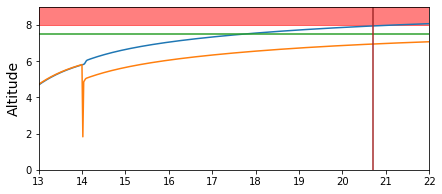

In [16]:
fig, ax = plt.subplots(figsize=(7, 3))
ax.set_ylim(0,9)
ax.set_xlim(13,22)
ax.plot(a.t_arr, a.y_real_arr,label='real')
ax.plot(a.t_arr, measures,label='measure')
ax.plot(a.t_arr, a.ref,label='ref')
ax.axhspan(8, 9, color='r', alpha=0.5)
ax.axvline((a.place+2+k)*a.Ts, color='brown',label='stable')
ax.set_ylabel('Altitude', fontsize=14)
# ax.legend()
fig.show()
fig.savefig('qd_unsafe_ref.pdf',bbox_inches='tight')
# fig.savefig('qd_safe.pdf',bbox_inches='tight')
# fig.savefig('vt_unsafe_thres.pdf',bbox_inches='tight')